In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
import pandas as pd

# Part 1 

For the first part, we will be working on the preprocessing of a dataset acquired using surface EMG on the forearm of a subject. The task was to perform grasping actions.

In [7]:
fs = 2400 # Sampling frequency (Hz)
EMG_file_name='./EMG_short.csv'
#load csv
EMG_df = pd.read_csv(EMG_file_name)
emg = EMG_df.values

# EMG.to_csv('EMG_short2.csv', index=False)
print(f'what is the shape of the data? {emg.shape}')
print(f'How many time amples are there? {emg.shape[0]}')
print(f'How many channels are there? {emg.shape[1]}')

what is the shape of the data? (240000, 5)
How many time amples are there? 240000
How many channels are there? 5


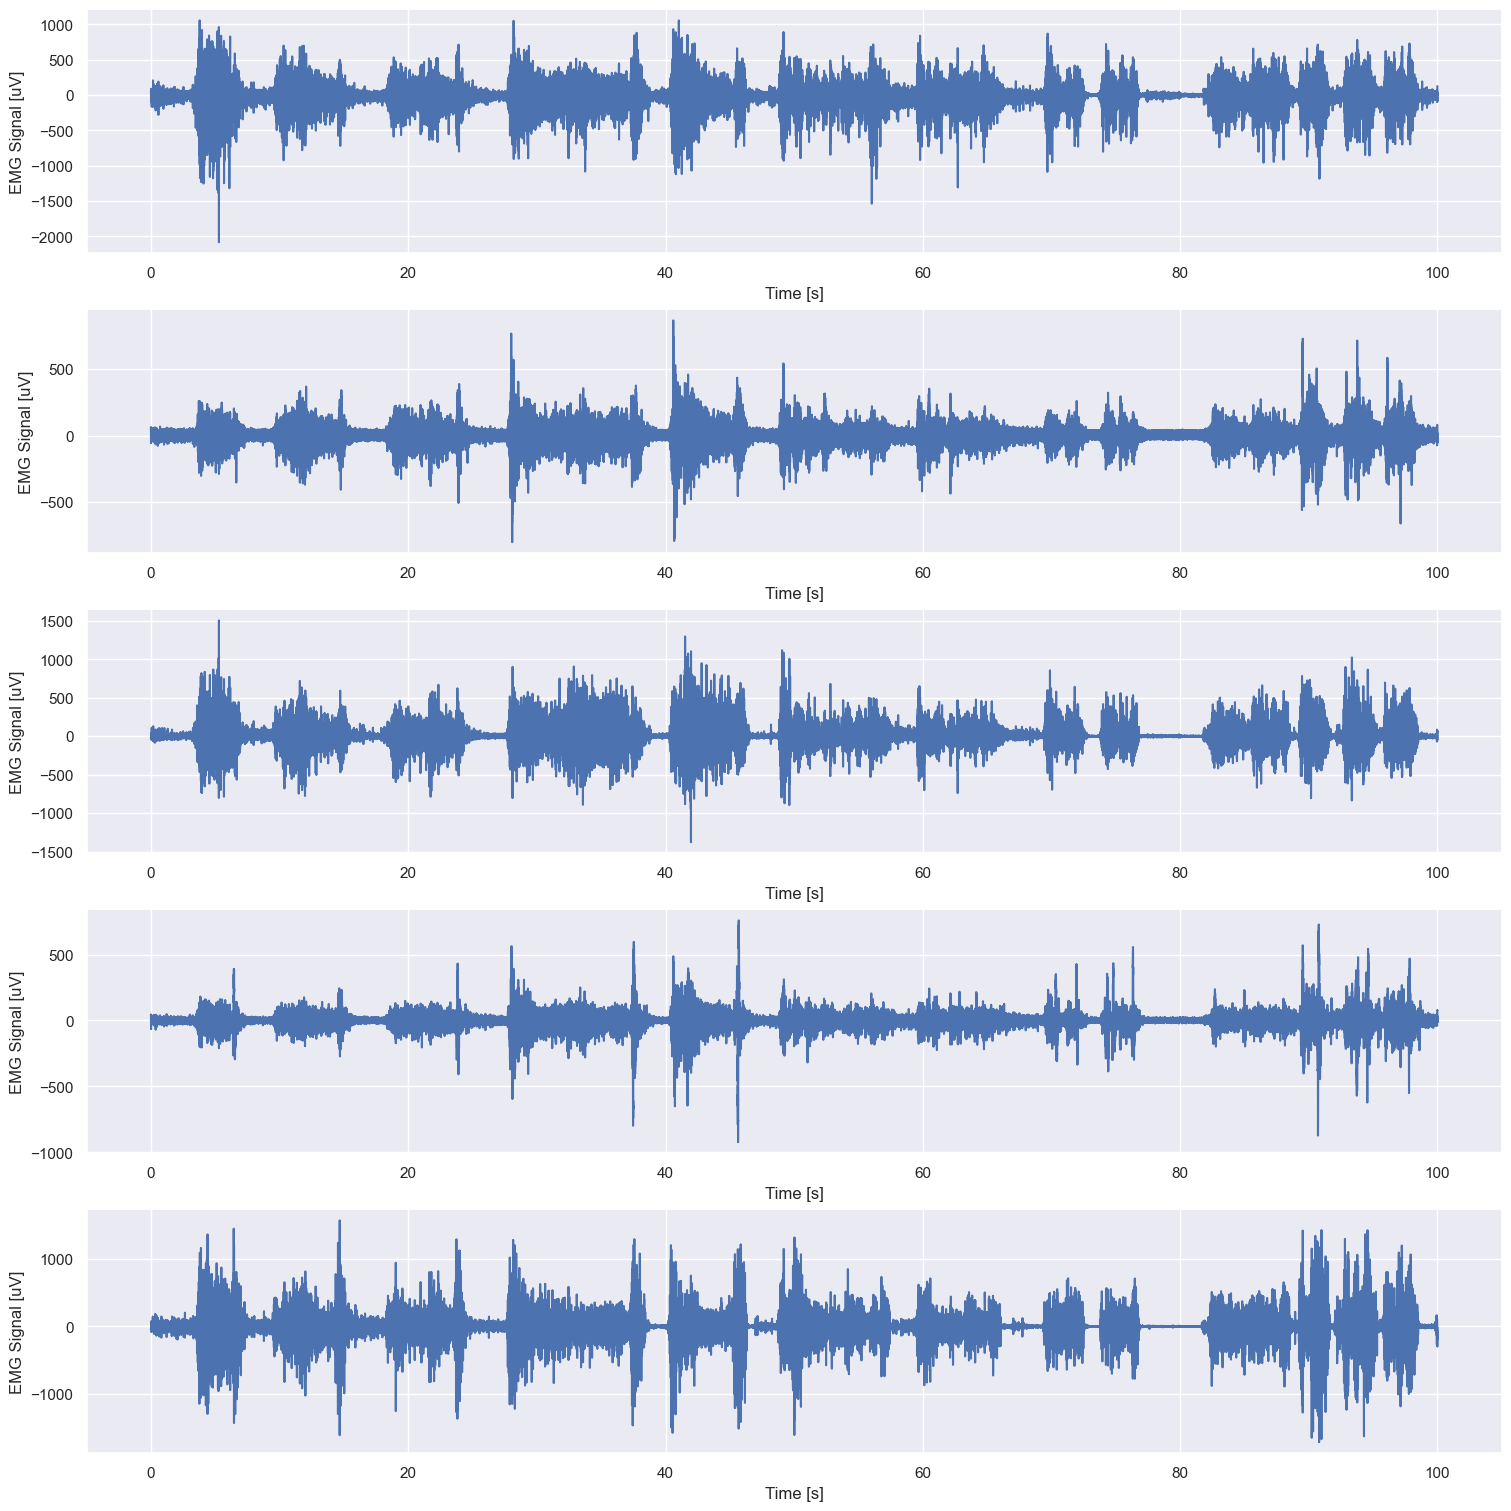

In [4]:
n_channels = emg.shape[1]

tsteps = np.arange(0, emg.shape[0]/fs, 1/fs) #Time vector for plotting

fig, ax = plt.subplots(n_channels, 1, constrained_layout=True, figsize=(15, 15))
for i in range(n_channels):
    ax[i].plot(tsteps, emg[:, i])
    ax[i].set_xlabel("Time [s]")
    ax[i].set_ylabel("EMG Signal [uV]")


As first preprocessing step, we need to apply a bandpass filter. In particular, in this case we use a butterworth filter between 5Hz and 500Hz. The lower bound removes mainly movement artefacts while the upper bound removes high-frequency noise. Also, we have to remember to remove the powergrid noise (50Hz and its harmonics).

Look at https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.sosfiltfilt.html


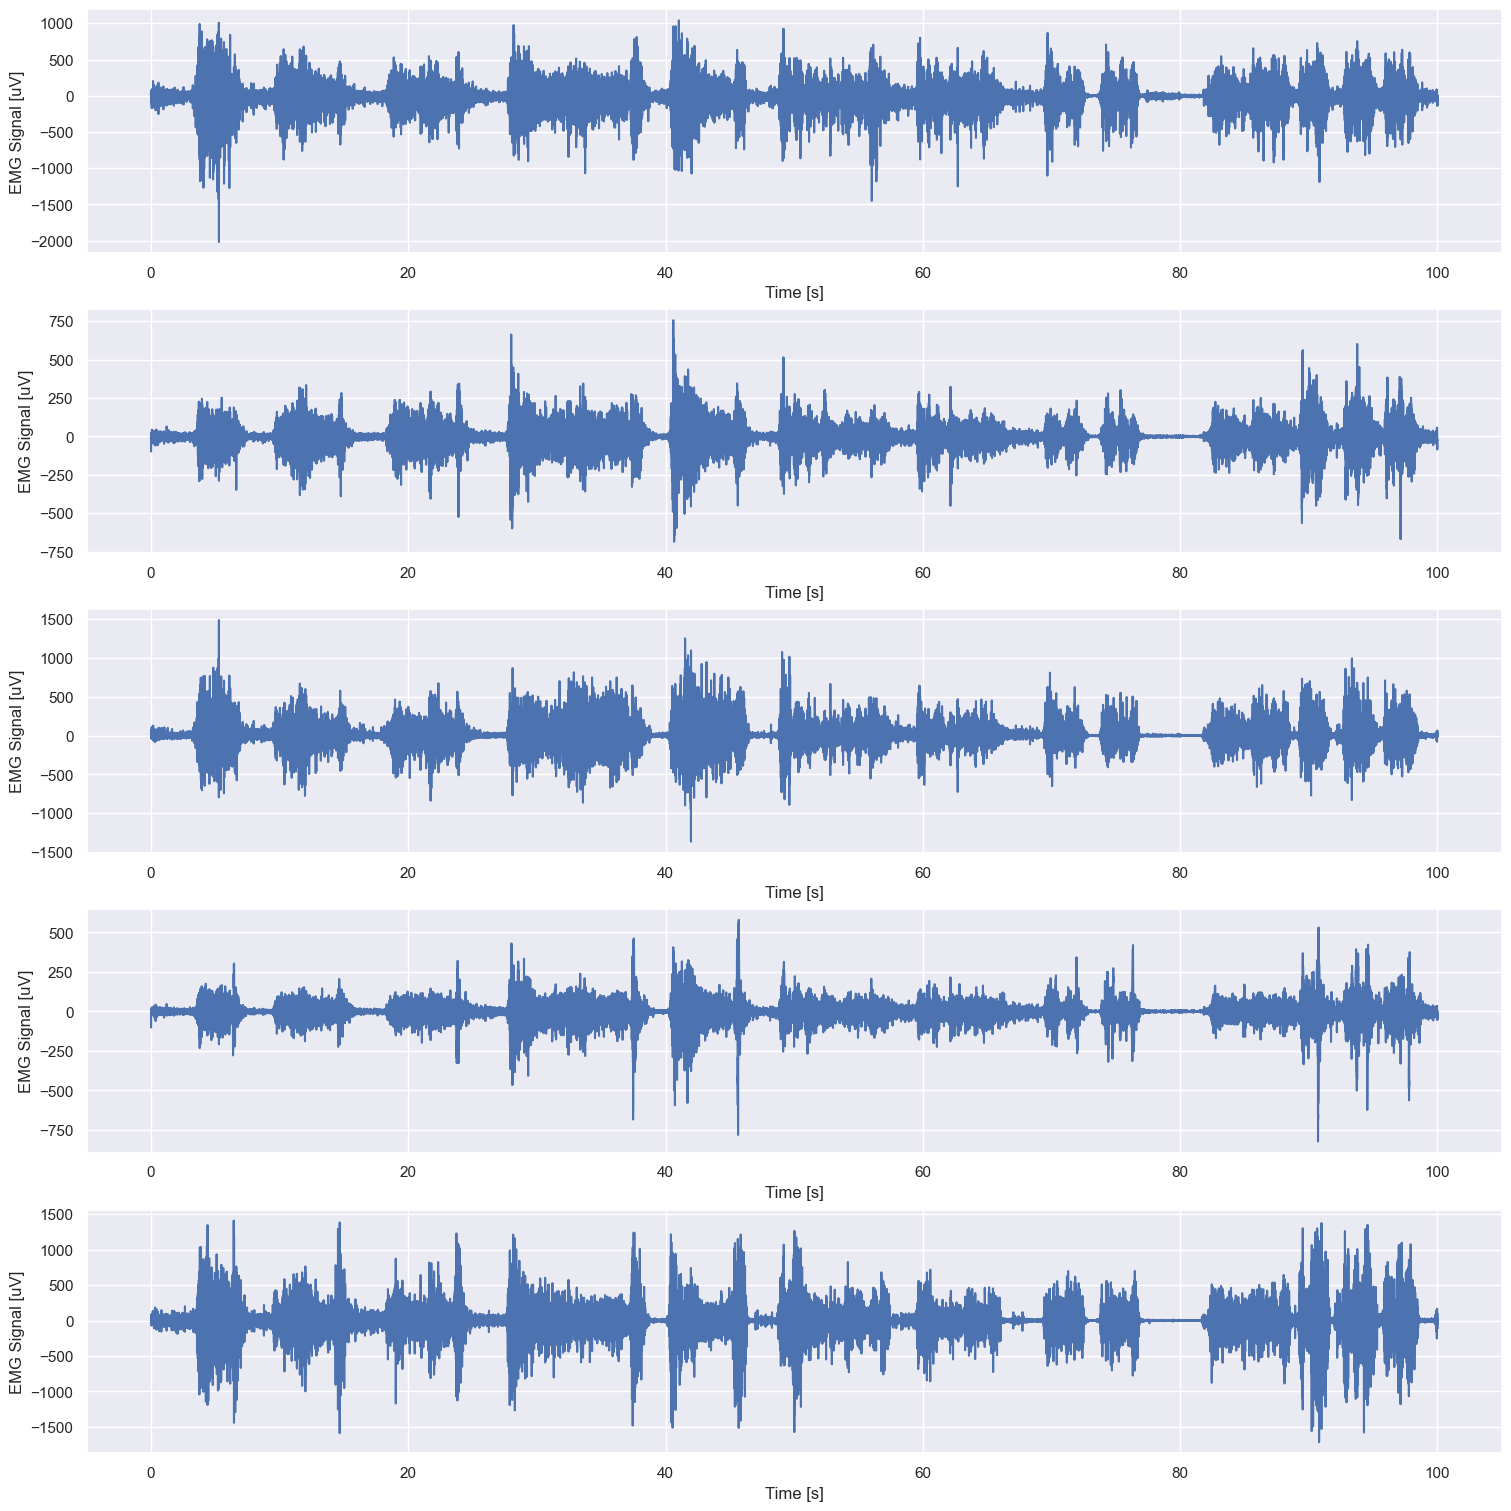

In [11]:
Wn = (5, 500) 
sos = butter(N=4, Wn=Wn, fs=fs, btype="bandpass", output="sos") 
emg_filtered = sosfiltfilt(sos, emg.T).T 

Wns = [(49, 51),
       (99, 101),
       (149, 151),
       (199, 201),
       (249, 251),
       (299, 301),
       (349, 351),
       (399, 401),
       (449, 451)] #??? removing 50Hz noise and its harmonics

for Wn in Wns:
    sos = butter(N=4, Wn=Wn, fs=fs, btype="bandstop", output="sos")
    emg_filtered = sosfiltfilt(sos, emg_filtered.T).T

fig, ax = plt.subplots(n_channels, 1, constrained_layout=True, figsize=(15, 15))
for i in range(n_channels):
    ax[i].plot(tsteps, emg_filtered[:, i])
    ax[i].set_xlabel("Time [s]")
    ax[i].set_ylabel("EMG Signal [uV]")

Let's check how the power spectral density changed after filtering.

Text(0.5, 1.0, 'Log scale for y-axis')

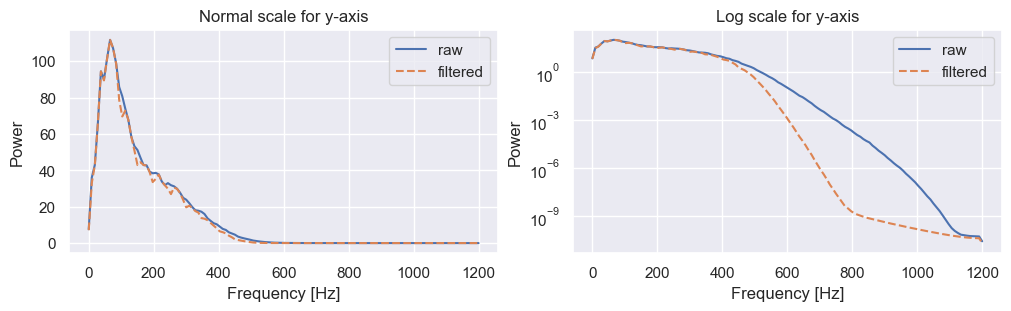

In [21]:
#Use Welch's method for power spectral density estimation, it reduces the variance of the estimate.
freqs_pre, Pxx_pre = welch(x=emg[:,0], fs=fs, axis=-1)
freqs_post, Pxx_post = welch(x=emg_filtered[:,0], fs=fs, axis=-1)

fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3))
ax[0].plot(freqs_pre, Pxx_pre, label="raw")
ax[0].plot(freqs_post, Pxx_post, linestyle="--", label="filtered")
ax[0].legend()
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_ylabel("Power")
ax[0].set_title("Normal scale for y-axis")

ax[1].semilogy(freqs_pre, Pxx_pre, label="raw")
ax[1].semilogy(freqs_post, Pxx_post, linestyle="--", label="filtered")
ax[1].legend()
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylabel("Power")
ax[1].set_title("Log scale for y-axis")

Now we rectify the signal in order to better quantify the muscular activation.

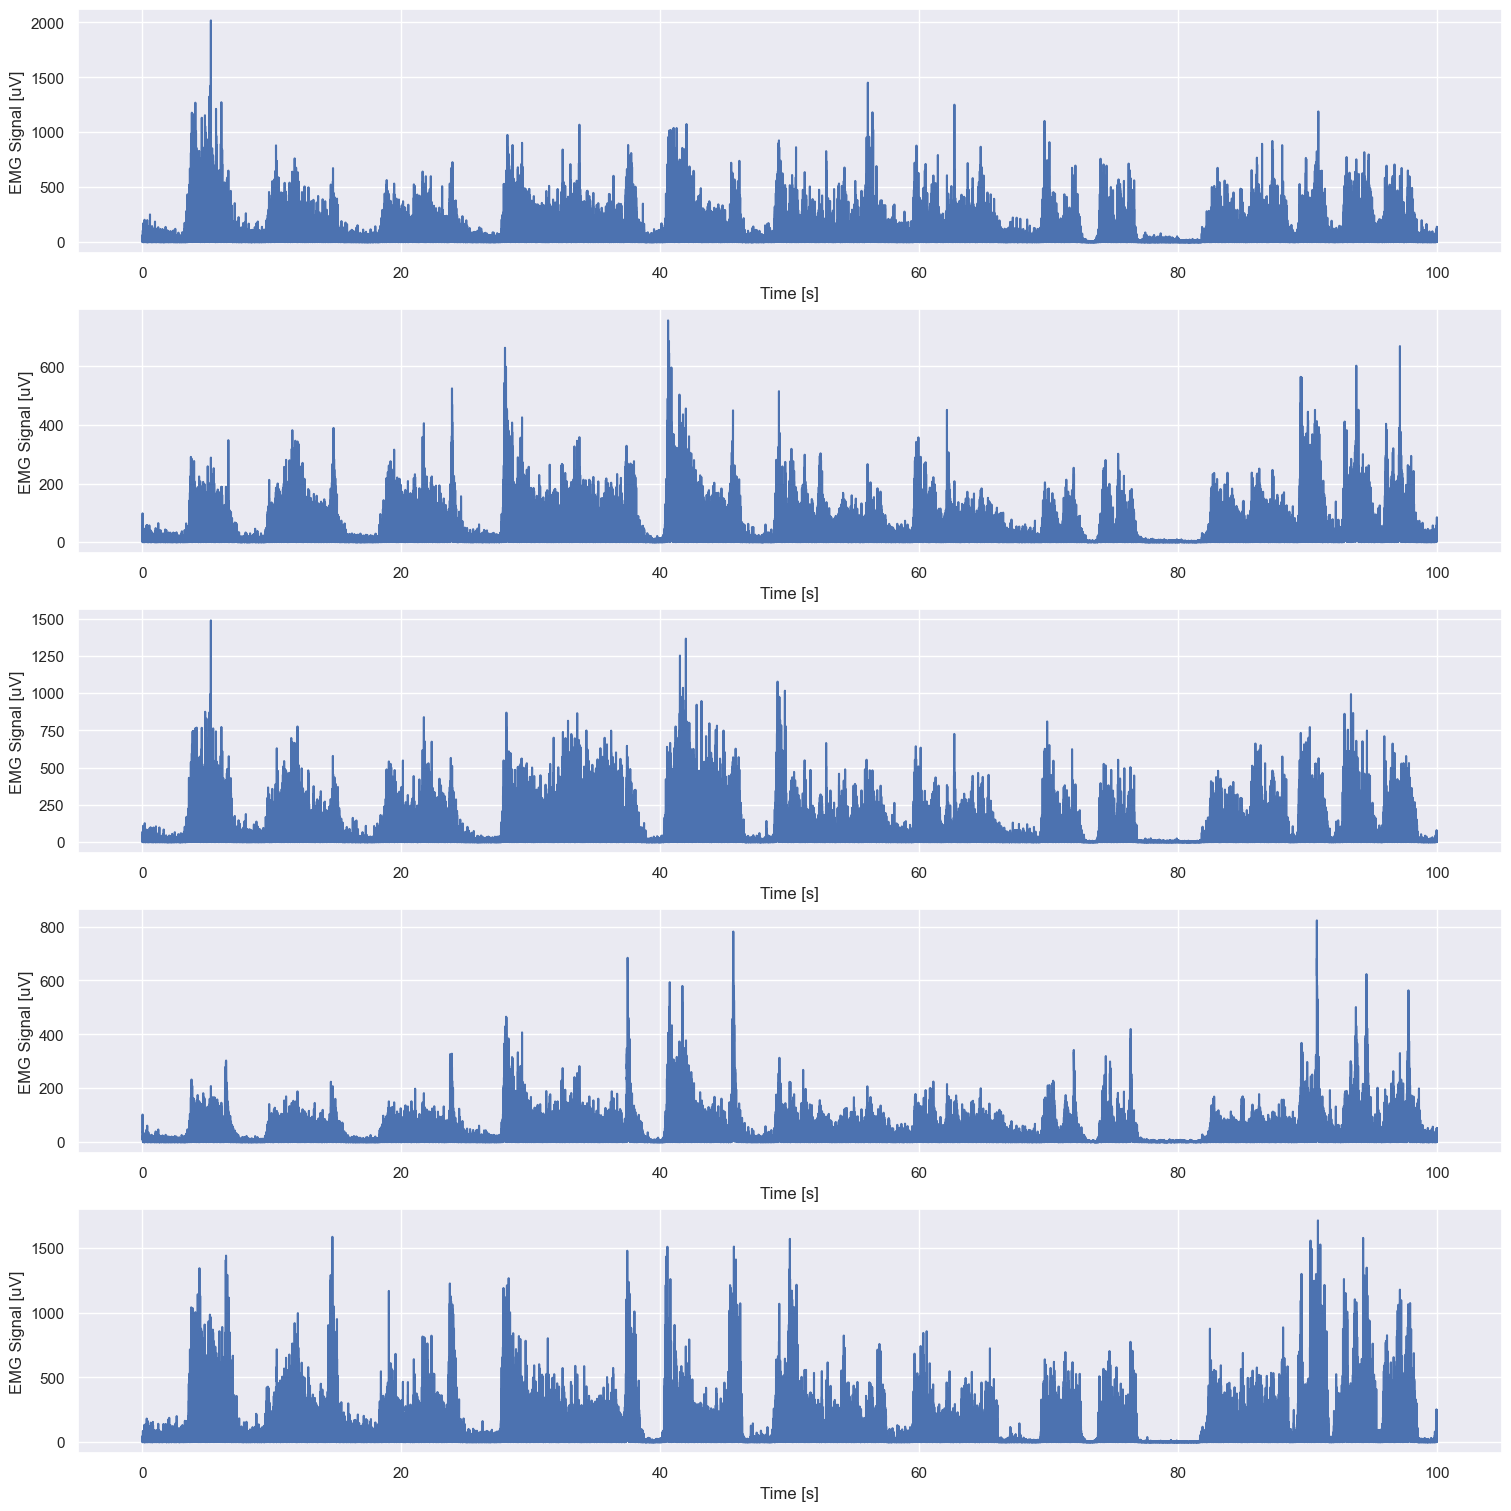

In [23]:
emg_rectified = np.abs(emg_filtered) # Rectify the signal

fig, ax = plt.subplots(n_channels, 1, constrained_layout=True, figsize=(15, 15))
for i in range(n_channels):
    ax[i].plot(tsteps, emg_rectified[:, i])
    ax[i].set_xlabel("Time [s]")
    ax[i].set_ylabel("EMG Signal [uV]")


As a last step, we compute the envelop of the signal by applying a moving average.

Text(0.5, 0.98, 'EMG envelopes')

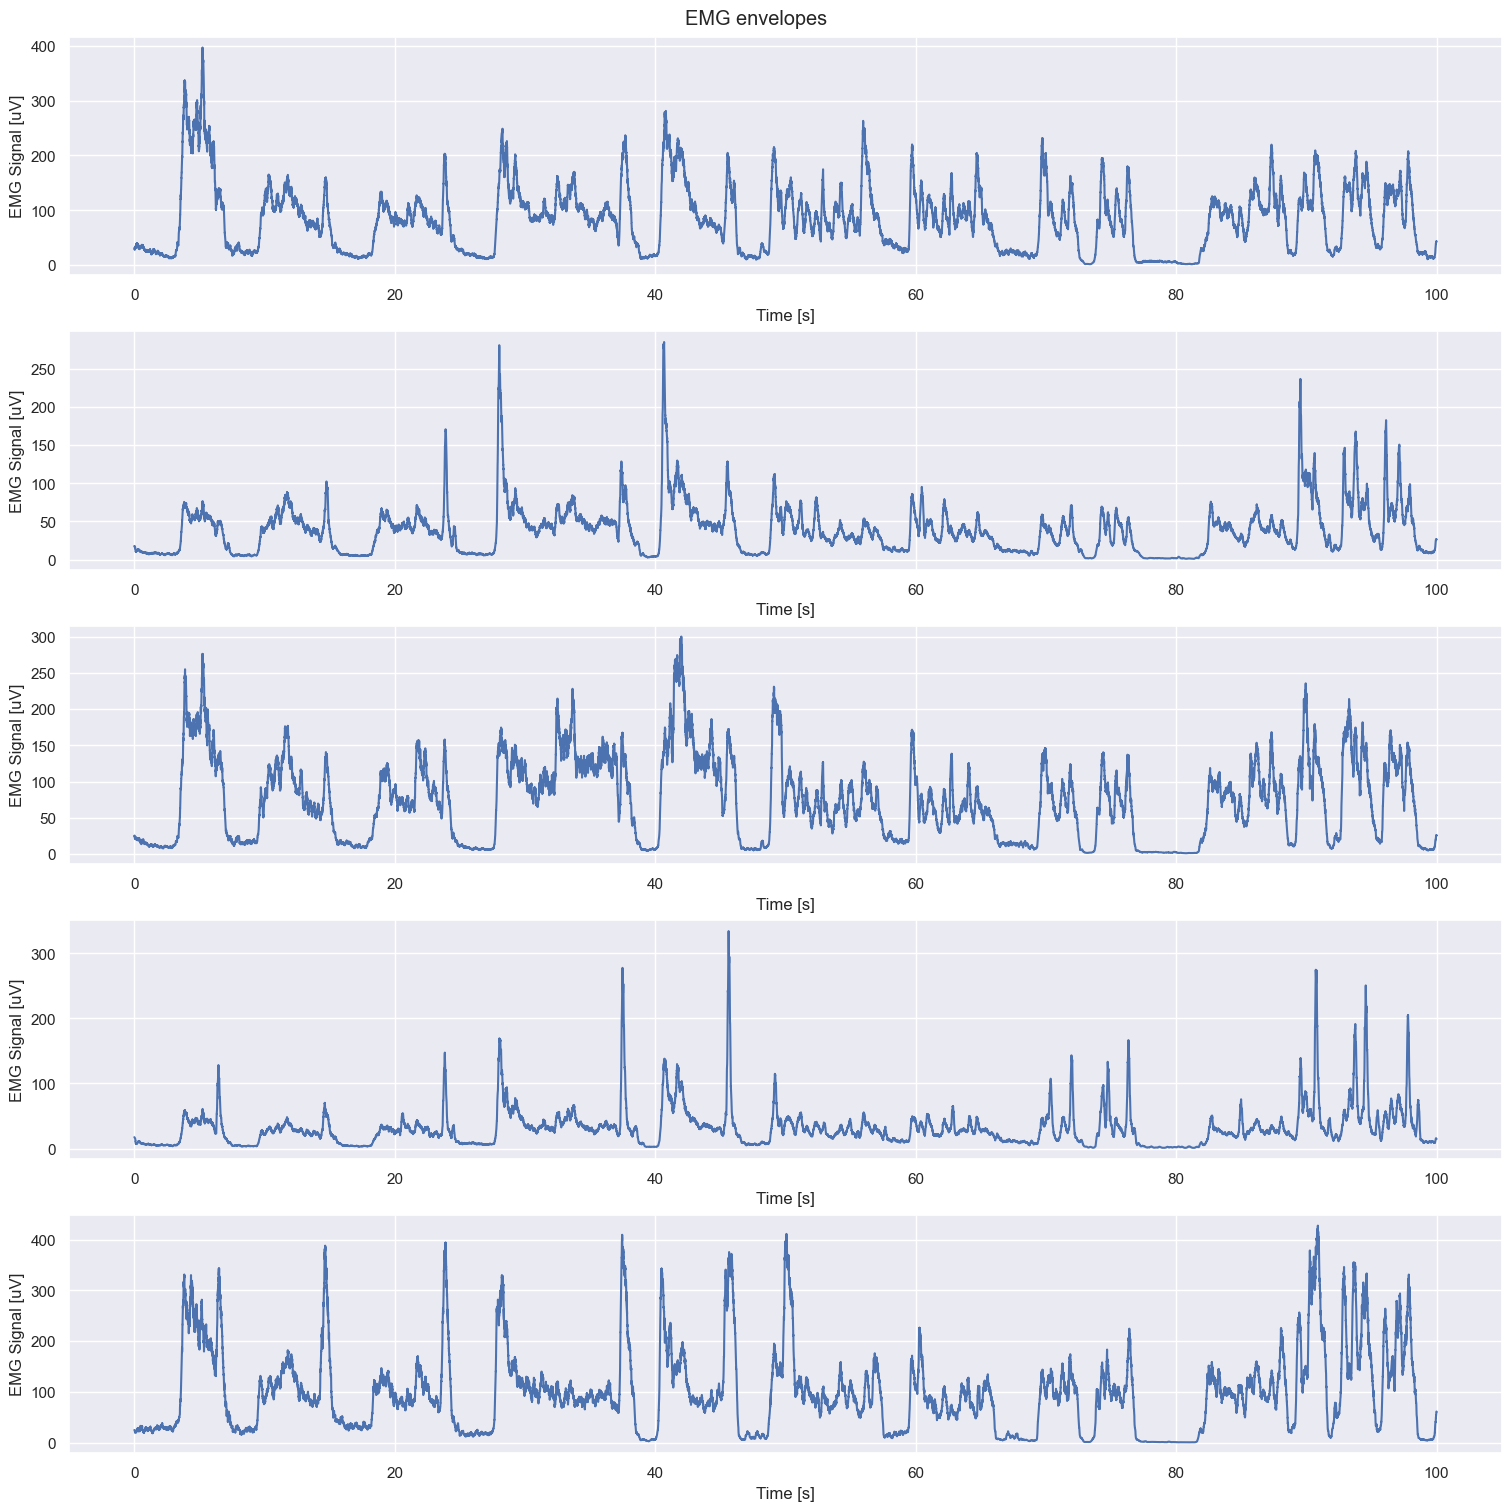

In [30]:
mov_mean_size = 400
mov_mean_weights = np.ones(mov_mean_size) / mov_mean_size
emg_envelopes = convolve1d(emg_rectified, mov_mean_weights, axis=0) # convolve1d the rectified signal with the moving average weights


fig, ax = plt.subplots(n_channels, 1, constrained_layout=True, figsize=(15, 15))
for i in range(n_channels):
    ax[i].plot(tsteps, emg_envelopes[:, i])
    ax[i].set_xlabel("Time [s]")
    ax[i].set_ylabel("EMG Signal [uV]")
plt.suptitle("EMG envelopes")

# Part 2

The dataset that we will be working with can be obtained from ninapro. After loading the data, we can see that it is a dictionary with different information.  Information about the different columns can be found in https://ninapro.hevs.ch/instructions/DB1.html. In essence, the data was acquired through 10 repetitions of 52 different movements (for this particular dataset, there are only 12). The subjects are asked to repeat movements which were shown as movies on the screen of a laptop. Also, note that these data are already partially preprocessed. 


In [2]:
data = loadmat("exercise_1__dataset_1.mat")
print(f"What kind of data structure are we working with? {type(data)}")
print(f"What are the keys of the data structure? {[i for i in data.keys()]}")

What kind of data structure are we working with? <class 'dict'>
What are the keys of the data structure? ['__header__', '__version__', '__globals__', 'emg', 'stimulus', 'glove', 'subject', 'exercise', 'repetition', 'restimulus', 'rerepetition']


Exploration of the data: For now, lets focus on three of the columns ['emg', 'restimulus', 'rerepetition']. If we print the shape of the array, first dimension of EMG column will correspond to the number of timesteps n_tsteps, while the second dimension are the different channels of electrodes. 

In [3]:
emg = data["emg"]

#Restimulus and rerepetition are the stimulus and repetition that have been processed for better correspondance to real movement
stimulus = data["restimulus"] #Stimulus is the type of movement that is being performed
repetition = data["rerepetition"] #Repetition is the number of times the movement has been repeated

print(f'What are the shape of the data that we are working with? EMG: {emg.shape}, Stimulus {stimulus.shape}, Repetition {repetition.shape}')

What are the shape of the data that we are working with? EMG: (101014, 10), Stimulus (101014, 1), Repetition (101014, 1)


We also see that there are 12 different types of movement.


In [39]:
n_stimuli = len(np.unique(stimulus)) - 1 # -1 because 0 is the resting condition
n_repetitions = len(np.unique(repetition)) - 1 # -1 because 0 is not a repetition
n_channels = emg.shape[1]

print(f'How many types of movement are there? {n_stimuli}') 
print(f'How many repetitions are there? {n_repetitions}') 

How many types of movement are there? 12
How many repetitions are there? 10


Next, let's look at how many samples (a.k.a timesteps) each trial (one combination of stimulation and repeats) has.

In [40]:
number_of_samples_per_trial = np.zeros((n_stimuli, n_repetitions))

for i in range(n_stimuli):
    for j in range(n_repetitions):
        
        idx = np.logical_and(stimulus == i+1, repetition == j+1)
        number_of_samples_per_trial[i, j] = np.sum(idx.astype(int))
        
number_of_samples_per_trial

array([[305., 354., 346., 371., 438., 372., 430., 412., 435., 352.],
       [193., 388., 233., 234., 244., 252., 316., 227., 229., 302.],
       [524., 390., 481., 433., 460., 515., 199., 360., 424., 356.],
       [348., 296., 287., 276., 281., 242., 278., 315., 330., 329.],
       [452., 453., 382., 416., 376., 418., 430., 339., 318., 368.],
       [293., 305., 432., 286., 301., 306., 254., 299., 253., 329.],
       [246., 240., 266., 263., 252., 187., 259., 325., 299., 278.],
       [211., 294., 277., 359., 333., 372., 374., 287., 306., 185.],
       [197., 250., 234., 222., 295., 281., 269., 330., 289., 241.],
       [458., 184., 184., 270., 407., 188., 338., 379., 473., 306.],
       [186., 285., 305., 195., 230., 240., 222., 318., 238., 272.],
       [341., 429., 189., 239., 526., 261., 185., 521., 224., 319.]])

We can see that the number of samples for each trial is different. This is because of the nature of the task they have to perform. The subjects were asked to repeat movements on shown on the screen, however the time taken for each movements might be different, some could be longer than the other. It will not be possible to fit it into a tensor (e.g. vector is a 1-dimensional tensor) directly as the size is not the same throughout. Therefore, we will be using a nested list to contain and access the data in the subsequent analysis. 

### Window and envelope
Now, lets visualize the data. In this example, we will illustrate using data from a single trial (repetition 1 of stimulus 1) we will be using moving average for detecting the envelope.

Text(0.5, 0.98, 'Windowned EMG signal')

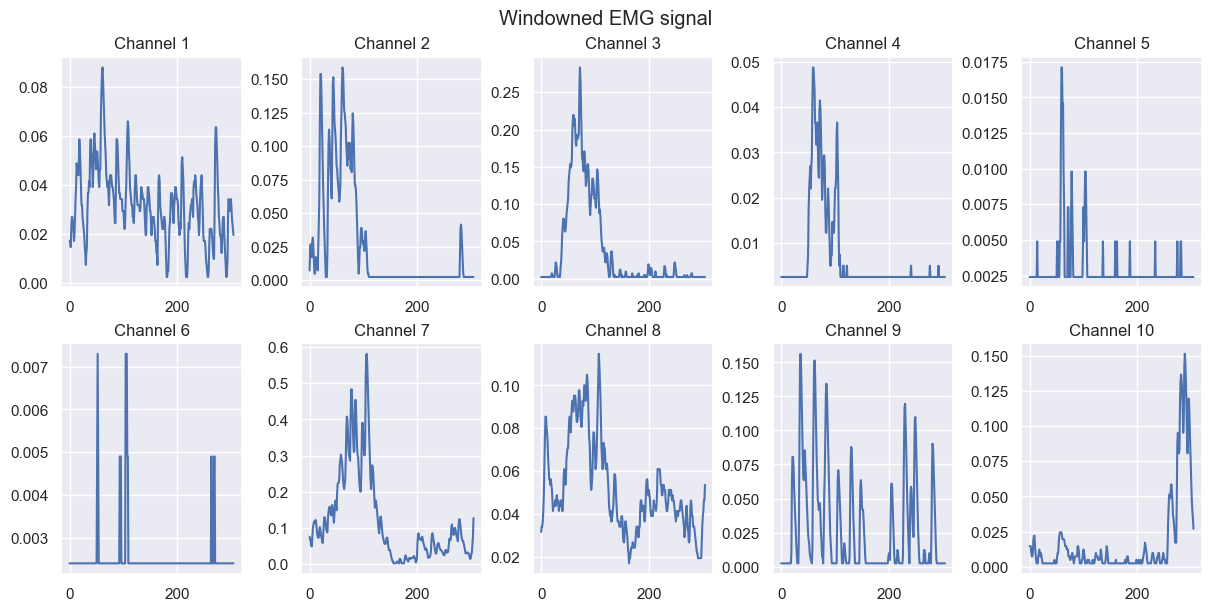

In [41]:
#defining the length of the moving average window
mov_mean_length = 25
mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length

#initializing the data structure
emg_windows = [[None for j in range(n_repetitions)] for i in range(n_stimuli)]
emg_rectified = [[None for j in range(n_repetitions)] for i in range(n_stimuli)]
emg_envelopes = [[None for j in range(n_repetitions)] for i in range(n_stimuli)]

for i in range(n_stimuli):
    for j in range(n_repetitions):

        idx = np.logical_and(stimulus == i + 1, repetition == j + 1).flatten()
        emg_windows[i][j] = emg[idx, :]
        emg_rectified[i][j] = np.abs(emg_windows[i][j])
        emg_envelopes[i][j] = convolve1d(emg_rectified[i][j], mov_mean_weights, axis=0)

fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True)
ax = ax.ravel()
for i in range(10):
    ax[i].plot(emg_windows[0][0][:, i])
    ax[i].set_title(f"Channel {i+1}")
plt.suptitle("Windowned EMG signal")

Text(0.5, 0.98, 'Envelopes of the EMG signal')

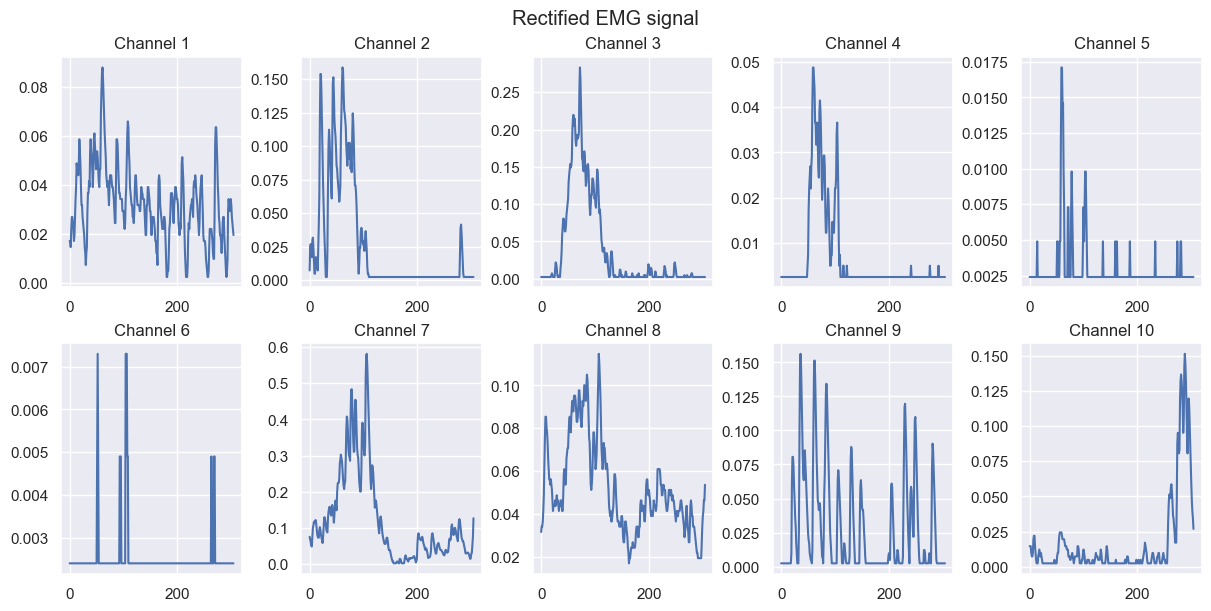

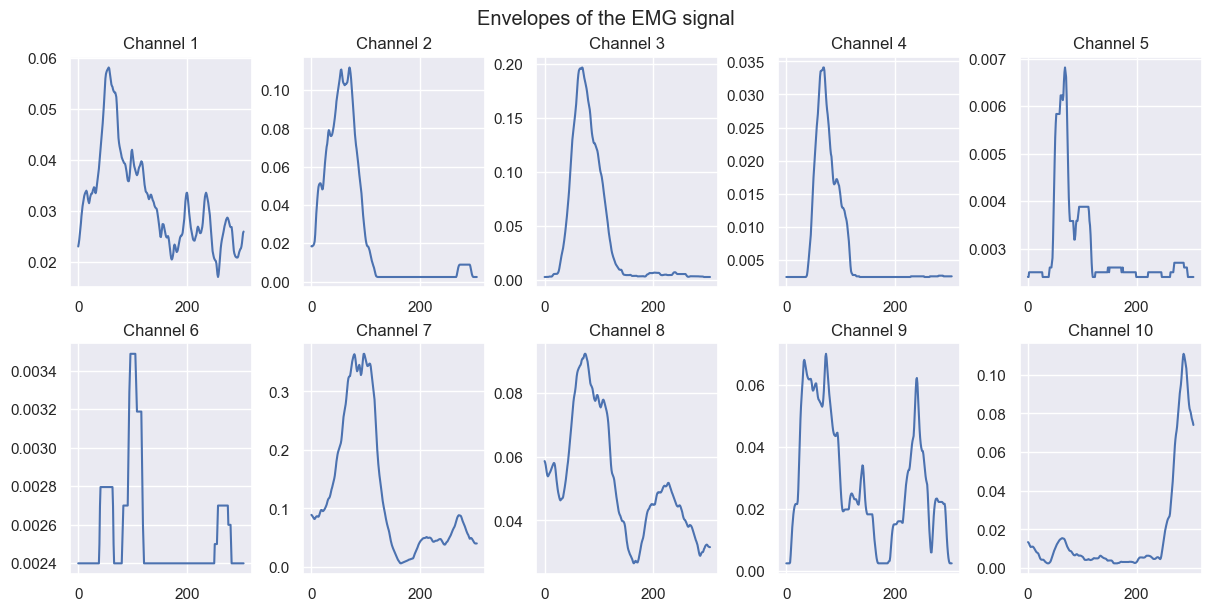

In [42]:
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True)
ax = ax.ravel()
for i in range(10):
    ax[i].plot(emg_rectified[0][0][:, i])
    ax[i].set_title(f"Channel {i+1}")
plt.suptitle("Rectified EMG signal")

fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True)
ax = ax.ravel()
for i in range(10):
    ax[i].plot(emg_envelopes[0][0][:, i])
    ax[i].set_title(f"Channel {i+1}")
plt.suptitle("Envelopes of the EMG signal")

From the plots, it seems that we already have the envelopes through moving average although high frequency signals might still be present. Moreover, weird looking plots might occur when using moving average (look at channel 5 and 6). Another method that is often used in literature is to use a low pass filter instead of applying the moving average. However, take note that it might produce regions where the enveloped is < 0. Running another round of rectification could introduce non-differentiability. Which could affect the subsequent analysis depending on the pipeline.

Text(0.5, 0.98, 'Envelopes of the EMG signal')

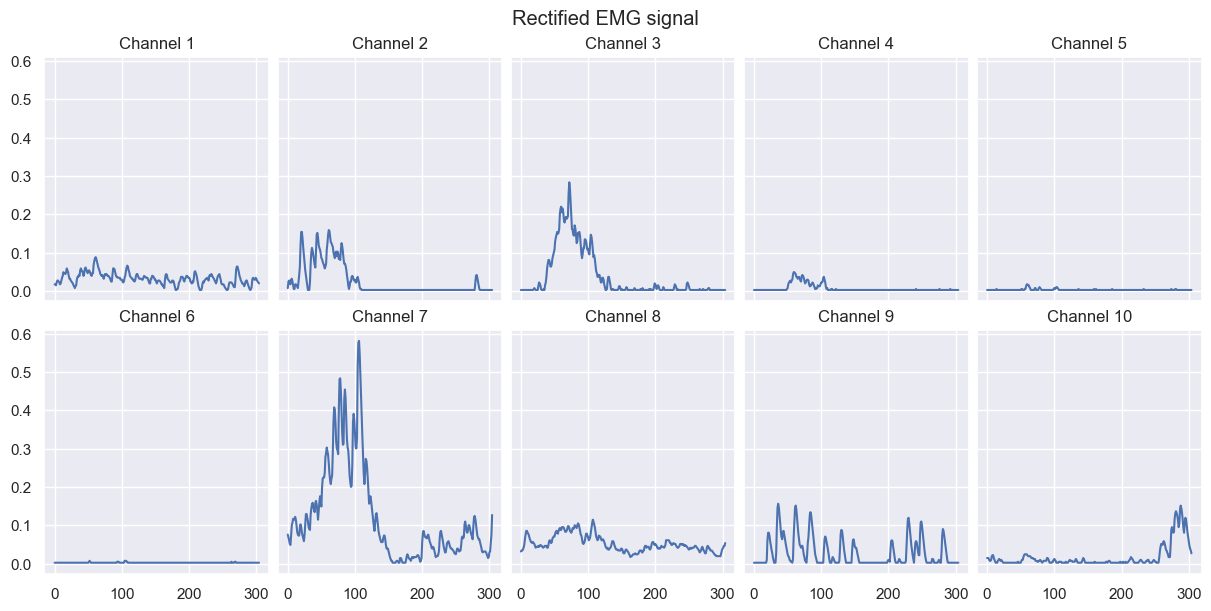

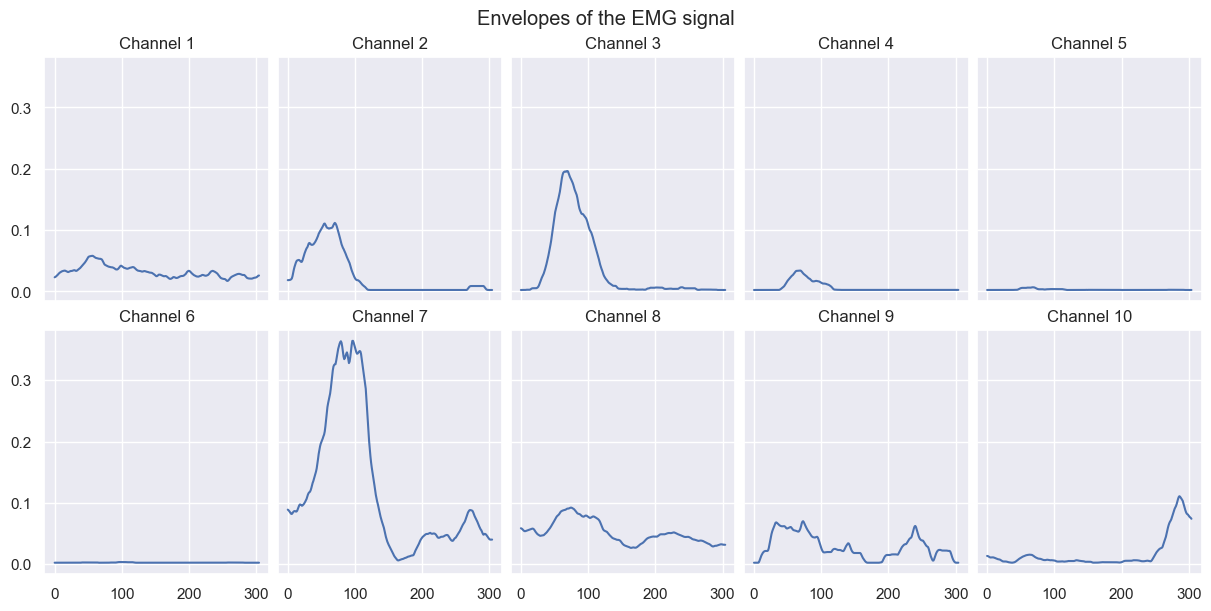

In [43]:
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()
for i in range(10):
    ax[i].plot(emg_windows[0][0][:, i])
    ax[i].set_title(f"Channel {i+1}")
plt.suptitle("Rectified EMG signal")

fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()
for i in range(10):
    ax[i].plot(emg_envelopes[0][0][:, i])
    ax[i].set_title(f"Channel {i+1}")
plt.suptitle("Envelopes of the EMG signal")


### Visualizing across repetitions

Remember that we were only looking at a single trial in the previous section. To check for the robustness of the signal, we will generally need to repeat the stimulus multiple times and look at the trend of the signal quality over time.

In [44]:
emg_average_activations = np.zeros((n_channels, n_stimuli, n_repetitions))
for i in range(n_stimuli):
    for j in range(n_repetitions):
        emg_average_activations[:, i, j] = np.mean(emg_envelopes[i][j], axis=0) #mean across time for each channel

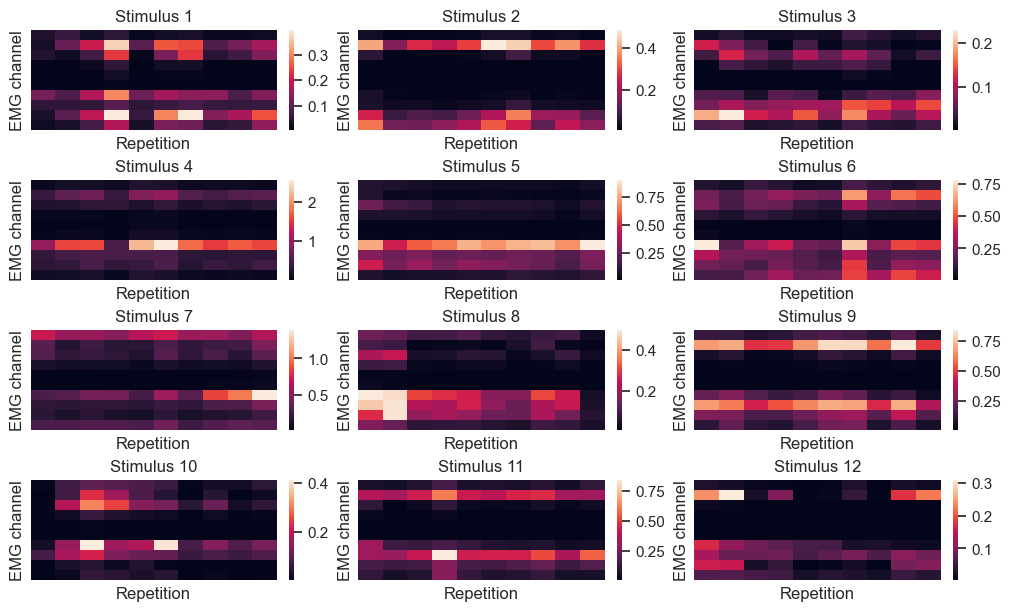

In [45]:
fig, ax = plt.subplots(4, 3, figsize=(10, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

for i in range(n_stimuli):
    sns.heatmap(np.squeeze(emg_average_activations[:, i, :]), ax=ax[i] ,xticklabels=False, yticklabels=False, cbar = True)
    ax[i].title.set_text("Stimulus " + str(i + 1))
    ax[i].set_xlabel("Repetition")
    ax[i].set_ylabel("EMG channel")

Does the structure seem homogeneous by row? Why?

Does the structure seem homogeneous by column? Why?

What can we say comparing the EMG recordings for different stimuli?